In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from numpy import random
class UAVenv(gym.Env):
    metadata = {'render.modes': ['human']}
    # Fixed Input Parameters
    NUM_USER = 100   # Number of ground user
    NUM_UAV = 5   # Number of UAV
    MAX_USER_COVER_EACH_UAV= 20  # Maximum Capacity for each UAV to cover users
    COVERAGE_XY = 1000
    grid_space = 100
    GRID_SIZE = int(COVERAGE_XY / grid_space)

    UAV_HEIGHT = 350
    THETA = 60 * math.pi / 180 # In radian

    ## Polar to Cartesian and vice versa
    def pol2cart(r,theta):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return (x, y)

    def cart2pol(x, y):
        theta = np.arctan2(y, x)
        r = np.hypot(x, y)
        return r, theta

    ############################################################################
    ##     User Distribution // Hotspots with Uniform Distribution      ##
    ############################################################################

    #SEED = 1
    #random.seed(SEED)

    #HOTSPOTS = np.array([[300, 300], [800, 800], [300, 800], [800, 300]])

    #USER_DIS = [15, 20, 30, 25]
    #USER_LOC = np.zeros((sum(USER_DIS) + 10, 3)) # +10 for 10 additional random users

    #start_index = 0
    #for i in range(len(HOTSPOTS)):
        #for j in range(start_index, start_index + USER_DIS[i]):
            #temp_loc_r = random.uniform(-(1/5)*COVERAGE_XY, (1/5)*COVERAGE_XY)
            #temp_loc_theta = random.uniform(0, 2*math.pi)
            #temp_loc = pol2cart(temp_loc_r, temp_loc_theta)
            #temp_loc_1, temp_loc_2 = temp_loc
            #temp_loc_1 = temp_loc_1 + HOTSPOTS[i, 0]
            #temp_loc_2 = temp_loc_2 + HOTSPOTS[i, 1]
            #USER_LOC[j, :] = [temp_loc_1, temp_loc_2, i]
        #start_index += USER_DIS[i]

    #temp_loc = np.random.uniform(low=0, high=COVERAGE_XY, size=(10, 2))
    #USER_LOC[start_index:start_index+10, :2] = temp_loc
    #USER_LOC[start_index:start_index+10, 2] = 4 # Assign region 4 to scattered users
    #np.savetxt('UserLocationNew.txt', USER_LOC, fmt='%.3e', delimiter=' ', newline='\n')

    #print(USER_LOC)
    # Plot users with different colors for different regions
    #fig = plt.figure(figsize=(6, 6), dpi=200)
    #gs = GridSpec(1, 1, figure=fig)
    #ax = fig.add_subplot(gs[0:1, 0:1])
    #ax.cla()
    #for i in range(USER_LOC.shape[0]):
        #if USER_LOC[i, 2] == 0:
            #co = '#CB4335'
        #elif USER_LOC[i, 2] == 1:
            #co = '#7D3C98'
        #elif USER_LOC[i, 2] == 2:
            #co = '#2E86C1'
        #elif USER_LOC[i, 2] == 3:
            #co = '#28B463'
        #elif USER_LOC[i, 2] == 4:
            #co = '#F1C40F'

        #ax.scatter(USER_LOC[i, 0], USER_LOC[i, 1], c=co, marker='o')
    USER_LOC = np.loadtxt('UserLocationNew.txt', delimiter=' ').astype(np.int64)

    def __init__(self):
        super(UAVenv, self).__init__()
        # Five different action for the movement of each UAV
        # 0 = Right, 1 = Left, 2 = straight, 3 = back, 4 = Hover
        # Position of the UAV in space // X and Y pos
        self.u_loc = self.USER_LOC
        self.state = np.zeros((self.NUM_UAV, 4))
        self.state[:,:2] = np.zeros((self.NUM_UAV, 2), dtype=np.int32)
        self.state[:,2] = np.zeros((self.NUM_UAV,), dtype=np.float32)
        self.state[:,3] = np.zeros((self.NUM_UAV,), dtype=np.float32)
        self.flag = [0, 0, 0, 0, 0]
        self.coverage_radius = self.UAV_HEIGHT * np.tan(self.THETA / 2)
        self.uav_assigned_to_jammed = None


    def step(self, action, reward, jammed_uav_index=None):
        # Take the action
        # Execution of one step within the environment
        # Deal with out of boundaries conditions
        isDone = False
        # Calculate the distance of every users to the UAV BS and organize as a list

        dist_u_uav = np.zeros(shape=(self.NUM_UAV, self.NUM_USER))

        for i in range(self.NUM_UAV):
            temp_x = self.state[i, 0]
            temp_y = self.state[i, 1]
            #print("Before action: ", (temp_x, temp_y))
            # one step action
            if action[i] == 0:
                self.state[i, 0] = self.state[i, 0] + 1
            elif action[i] == 1:
                self.state[i, 0] = self.state[i, 0] - 1
            elif action[i] == 2:
                self.state[i, 1] = self.state[i, 1] + 1
            elif action[i] == 3:
                self.state[i, 1] = self.state[i, 1] - 1
            elif action[i] == 4:
                pass
            else:
                print("Error Action Value")

            # Take boundary condition into account // Individual flag for punishing the UAV
            if self.state[i,0] < 0 or self.state[i,0] > self.GRID_SIZE or self.state[i, 1] < 0 or self.state[i,1] > self.GRID_SIZE:
                self.state[i, 0] = temp_x
                self.state[i, 1] = temp_y
                self.flag[i] = 1     # Later penalize the reward value based on the flag
            else:
              self.flag[i] = 0

            #print("After action: ", (self.state[i, 0], self.state[i, 1]))


            # Calculation of the distance value for all UAV and User
            for l in range(self.NUM_USER):
                dist_u_uav[i, l] = math.sqrt((self.u_loc[l, 0] - (self.state[i, 0] * self.grid_space)) ** 2 + (self.u_loc[l, 1] -(self.state[i, 1] * self.grid_space)) ** 2)


        ######################
        ## Final Algorithm  ##
        ######################

        # User association to the UAV based on the distance value. First do a single sweep by all
        # the Users to request to connect to the closest UAV After the first sweep is complete the UAV will admit a
        # certain Number of Users based on capacity. In the second sweep the User will request to the UAV
        # that is closest to it and UAV will admit the User if UAV has not reached its maximum capacity.

        # Connection request is a np array matrix that contains UAV Number as row and
        # User Number Connected to it on Columns and is stored in individual UAV to keep track of the
        # User requesting to connect
        # Initialize the connection_request table with zeros
        connection_request = np.zeros(shape=(self.NUM_UAV, self.NUM_USER), dtype="int")
        for i in range(self.NUM_USER):
            close_uav = np.argmin(dist_u_uav[:, i])
            if dist_u_uav[close_uav, i] <= self.coverage_radius:
                connection_request[close_uav, i] = 1

        user_asso_flag = np.zeros((self.NUM_UAV, self.NUM_USER), dtype="int")
        uav_asso_count = np.zeros(self.NUM_UAV, dtype="int")

        for i in range(self.NUM_UAV):
            if i == jammed_uav_index:
                continue

            temp_user = np.where(connection_request[i, :] == 1)
            temp_user_distance = dist_u_uav[i, temp_user]
            temp_user_sorted = np.argsort(temp_user_distance)
            temp_user = np.array(temp_user)
            temp_user_actual_idx = temp_user[0, temp_user_sorted]

            for user_index in temp_user_actual_idx[0]:
                if uav_asso_count[i] < self.MAX_USER_COVER_EACH_UAV:
                    user_asso_flag[i, user_index] = 1
                    uav_asso_count[i] += 1
                else:
                    break

        for j in range(self.NUM_USER):
            if not np.any(user_asso_flag[:, j] != 0):
                close_uav_id = dist_u_uav[:, j]
                close_uav_id = [i[0] for i in sorted(enumerate(close_uav_id), key=lambda x: x[1])]
                for close_id in close_uav_id:
                    if close_id == jammed_uav_index:
                        continue
                    if dist_u_uav[close_id, j] <= self.coverage_radius:
                        if np.sum(user_asso_flag[close_id]) < self.MAX_USER_COVER_EACH_UAV:
                            uav_asso_count[close_id] += 1
                            user_asso_flag[close_id, j] = 1
                            break
        if jammed_uav_index is not None:
            # Exclude the jammed UAV and UAVs in transit when finding the UAV with the minimum users
            valid_uav_indices = [i for i in range(self.NUM_UAV) if i != jammed_uav_index and self.state[i, 2] != 0]

            # Check if the jammed UAV is covering more users than any other UAV
            jammed_uav_users = uav_asso_count[jammed_uav_index]
            min_users_other_uavs = np.min(uav_asso_count[valid_uav_indices])

            if jammed_uav_users > min_users_other_uavs:
                # Check if we already have a UAV assigned to handle the jammed UAV
                if self.uav_assigned_to_jammed is None:
                    print("Valid UAV indices:", valid_uav_indices)  # Print the valid indices
                    uav_with_min_users = valid_uav_indices[np.argmin(uav_asso_count[valid_uav_indices])]
                    self.uav_assigned_to_jammed = uav_with_min_users
                else:
                    uav_with_min_users = self.uav_assigned_to_jammed

                # Example positions
                current_position = self.state[uav_with_min_users, :2].astype(int)
                target_position = self.state[jammed_uav_index, :2].astype(int)
                print(f"Starting at position: {current_position}")

                if not np.array_equal(current_position, target_position):
                    # Calculate direction vector
                    direction_vector = target_position - current_position

                    # Determine step direction in integer units
                    step_x = int(np.sign(direction_vector[0]))
                    step_y = int(np.sign(direction_vector[1]))

                    # Move UAV by one step
                    next_position = current_position + np.array([step_x, step_y])
                    self.state[uav_with_min_users, :2] = next_position
                    print(f"Moving to position: {next_position}")
                else:
                    self.uav_assigned_to_jammed = None  # Reset once the target is reached


            # Re-associate users for the UAV that moved to the jammed UAV's position
            connection_request[jammed_uav_index, :] = 0  # Clear previous connections of jammed UAV

            for i in range(self.NUM_USER):
                close_uav = np.argmin(dist_u_uav[:, i])
                if dist_u_uav[close_uav, i] <= self.coverage_radius:
                    connection_request[close_uav, i] = 1

            uav_asso_count = np.zeros(self.NUM_UAV, dtype="int")
            user_asso_flag = np.zeros((self.NUM_UAV, self.NUM_USER), dtype="int")

            for i in range(self.NUM_UAV):
                if i == jammed_uav_index:
                    continue

                temp_user = np.where(connection_request[i, :] == 1)
                temp_user_distance = dist_u_uav[i, temp_user]
                temp_user_sorted = np.argsort(temp_user_distance)
                temp_user = np.array(temp_user)
                temp_user_actual_idx = temp_user[0, temp_user_sorted]

                for user_index in temp_user_actual_idx[0]:
                    if uav_asso_count[i] < self.MAX_USER_COVER_EACH_UAV:
                        user_asso_flag[i, user_index] = 1
                        uav_asso_count[i] += 1
                    else:
                        break

        for j in range(self.NUM_USER):
            if not np.any(user_asso_flag[:, j] != 0):
                close_uav_id = dist_u_uav[:, j]
                close_uav_id = [i[0] for i in sorted(enumerate(close_uav_id), key=lambda x: x[1])]
                for close_id in close_uav_id:
                    if close_id == jammed_uav_index:
                        continue
                    if dist_u_uav[close_id, j] <= self.coverage_radius:
                        if np.sum(user_asso_flag[close_id]) < self.MAX_USER_COVER_EACH_UAV:
                            uav_asso_count[close_id] += 1
                            user_asso_flag[close_id, j] = 1
                            break

        sum_user_assoc = np.sum(user_asso_flag, axis = 1)
        self.state[:, 2] = sum_user_assoc / self.MAX_USER_COVER_EACH_UAV

        overall_coverage_rate = np.sum(uav_asso_count) / self.NUM_USER
        #print(overall_coverage_rate)
        self.state[:, 3] = np.ones(self.NUM_UAV) * overall_coverage_rate


        # Calculation of reward function
        sum_user_assoc = np.sum(user_asso_flag, axis = 1)
        sum_user_assoc_temp = np.copy(sum_user_assoc)
        reward_ind = np.zeros(np.size(sum_user_assoc))
        reward = 0
        for k in range(self.NUM_UAV):
            if k == jammed_uav_index:
                continue
            if self.flag[k] != 0:
                # Only penalized if the respective UAV is out of bound
                sum_user_assoc_temp[k] -= 2
                reward_ind[k] = np.average(sum_user_assoc_temp)
                isDone = True
            else:
                reward_ind[k] = np.average(sum_user_assoc)
        reward = np.copy(reward_ind)



        # Return of obs, reward, done, info
        return np.copy(self.state), reward, isDone, "empty", np.sum(sum_user_assoc)

    # Render Function
    def render(self, ax, mode='animation', close=False):
        # Implement viz
        if mode == 'animation':
            ax.cla()
            position = self.state[:, 0:2] * self.grid_space

            # Define colors for different regions
            region_colors = {
                0: '#CB4335',
                1: '#7D3C98',
                2: '#2E86C1',
                3: '#28B463',
                4: '#F1C40F'
            }
            # Define markers for different UAVs
            markers = ['x', 'p', 's', '^', 'd']
            # Plot users with label "Users" for all regions
            for region, color in region_colors.items():
                ax.scatter(self.u_loc[self.u_loc[:, 2] == region, 0], self.u_loc[self.u_loc[:, 2] == region, 1], c=color,
                          marker='o', label="Users")
            #ax.scatter(position[:, 0], position[:, 1], c='#000000', marker='x', label="UAV")
            for i, (x, y) in enumerate(position):
                cc = plt.Circle((x, y), self.coverage_radius, alpha=0.1)
                ax.set_aspect(1)
                ax.add_artist(cc)
                ax.scatter(x, y, c='black', marker=markers[i], label=f"UAV {i+1}")
            ax.set_xlim(-50, 1050)
            ax.set_ylim(-50, 1050)


    def reset(self):
        # reset out states
        self.state[:, 0:4] = [[0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0], [0, 0, 0.0, 0.0]]
        return self.state

    def get_state(self):
        state_loc = np.zeros((self.NUM_UAV, 4))
        for k in range(self.NUM_UAV):
            state_loc[k, 0] = self.state[k, 0]
            state_loc[k, 1] = self.state[k, 1]
            state_loc[k, 2] = self.state[k, 2]
            state_loc[k, 3] = self.state[k, 3]
        return state_loc


In [ ]:
# Extended version of render function to plot best state and final state of the UAVs
env=UAVenv()
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import math

def final_render(state, remark):
    USER_LOC = np.loadtxt('UserLocationNew.txt', dtype=np.int32, delimiter=' ')
    u_loc = USER_LOC
    fig = plt.figure()
    gs = GridSpec(1, 1, figure=fig)
    ax = fig.add_subplot(gs[0:1, 0:1])
    grid_space = 100
    UAV_HEIGHT = 350
    THETA = 60 * math.pi / 180
    coverage_radius = UAV_HEIGHT * np.tan(THETA / 2)

    ax.cla()
    position = state[:, 0:2] * grid_space

    # Define colors for different regions
    region_colors = {
        0: '#CB4335',
        1: '#7D3C98',
        2: '#2E86C1',
        3: '#28B463',
        4: '#F1C40F'
    }

    # Define markers for different UAVs
    markers = ['x', 'p', 's', '^', 'd']
    # Plot users with label "Users" for all regions
    for region, color in region_colors.items():
        ax.scatter(u_loc[u_loc[:,2] == region, 0], u_loc[u_loc[:,2] == region, 1], c = color, marker='o', label = "Users")

    #ax.scatter(position[:, 0], position[:, 1], c = '#000000', marker='x', label = "UAV")
    for i, (x, y) in enumerate(position):
        cc = plt.Circle((x, y), coverage_radius, alpha=0.1)
        ax.set_aspect(1)
        ax.add_artist(cc)
        ax.scatter(x, y, c='black', marker=markers[i], label=f"UAV {i+1}")
    #ax.legend()
    if remark == "best":
        plt.title("Best state of UAV")
    elif remark == "final":
        plt.title("Final state of UAV")
    plt.pause(0.5)
    plt.xlim(-50, 1050)
    plt.ylim(-50, 1050)
    plt.show()

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

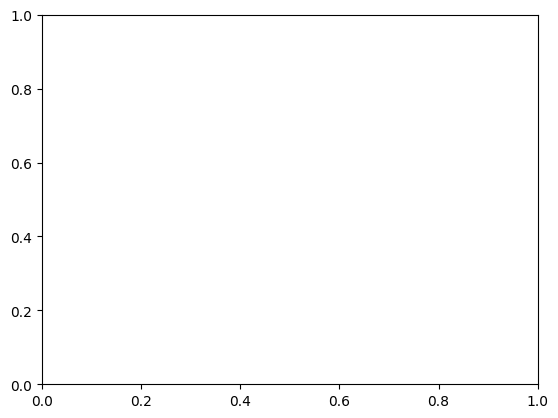

In [2]:
# Main Function

from ast import Num
import random
import numpy as np
import math
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from collections import deque
import torch
from torch import Tensor, nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
import os
from scipy.io import savemat

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

## GPU configuration use for faster processing
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = "cpu"


# DNN modeling
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(NeuralNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear_stack = model = nn.Sequential(
            nn.Linear(self.state_size,400),
            nn.ReLU(),
            nn.Linear(400,400),
            nn.ReLU(),
            nn.Linear(400, self.action_size)
        ).to(device=device)

    def forward(self, x):
        x = x.to(device)
        Q_values = self.linear_stack(x)
        return Q_values

class DQL:
    # Initializing a Deep Neural Network
    def __init__(self):
        self.state_size = 4
        self.action_size = 5
        self.replay_buffer = deque(maxlen = 125000)
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.learning_rate = alpha
        self.main_network = NeuralNetwork(self.state_size, self.action_size).to(device)
        self.target_network = NeuralNetwork(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.main_network.state_dict())
        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr = self.learning_rate)
        self.loss_func = nn.SmoothL1Loss()      # Huber Loss // Combines MSE and MAE
        self.steps_done = 0

    # Storing information of individual UAV information in their respective buffer
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))


    # Deployment of epsilon greedy policy
    def epsilon_greedy(self, state):
        temp = random.random()
        self.steps_done += 1
        if temp <= self.epsilon:
            action = torch.tensor([[np.random.randint(0, 4)]], device = device, dtype = torch.long)
        else:
            state = torch.unsqueeze(torch.FloatTensor(state),0)
            Q_values = self.main_network(state)
            action = Q_values.max(1)[1].view(1,1)
        return action

    # Training of the DNN
    def train(self,batch_size):
      minibatch = random.sample(self.replay_buffer, batch_size)
      minibatch = np.array(minibatch,dtype=object)
      minibatch = minibatch.reshape(batch_size,5)
      state = torch.FloatTensor(np.vstack(minibatch[:,0]))
      action = torch.LongTensor(np.vstack(minibatch[:,1]))
      reward = torch.FloatTensor(np.vstack(minibatch[:,2]))
      next_state = torch.FloatTensor(np.vstack(minibatch[:,3]))
      done = torch.Tensor(np.vstack(minibatch[:,4]))
      state = state.to(device = device)
      action = action.to(device = device)
      reward = reward.to(device = device)
      next_state = next_state.to(device = device)
      done = done.to(device = device)

      Q_next = self.target_network(next_state).detach()
      target_Q = reward.cpu().squeeze() + self.gamma * Q_next.cpu().max(1)[0].view(batch_size, 1).squeeze() * (
                1 - np.array([state[e].cpu().mean() == next_state[e].cpu().mean() for e in range(len(next_state))])
            )

      # Forward
      # Loss calculation based on loss function
      target_Q = target_Q.float()
      Q_main = self.main_network(state).gather(1, action).squeeze()
      loss = self.loss_func(target_Q.cpu().detach(), Q_main.cpu())
      # Backward
      self.optimizer.zero_grad()
      loss.backward()
      # For gradient clipping
      for param in self.main_network.parameters():
          param.grad.data.clamp_(-1,1)
      # Gradient descent
      self.optimizer.step()


u_env = UAVenv()
GRID_SIZE = u_env.GRID_SIZE
NUM_UAV = u_env.NUM_UAV
NUM_USER = u_env.NUM_USER
num_episode = 750
num_epochs = 100
discount_factor = 0.95
alpha = 3.5e-4
batch_size = 512
update_rate = 10  #50
epsilon = 0.10
random.seed(SEED)



# Keeping track of the episode reward
episode_reward = np.zeros(num_episode)
episode_user_connected = np.zeros(num_episode)

fig = plt.figure()
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0:1, 0:1])

#creating object for 5 UAVs
UAV_OB = [None, None, None, None, None]


for k in range(NUM_UAV):
            UAV_OB[k] = DQL()
best_result = 0

for i_episode in range(num_episode):
    print(i_episode)

    # Environment reset and get the states
    u_env.reset()

    # Get the initial states
    states = u_env.get_state()
    reward = np.zeros(NUM_UAV)


    for t in range(num_epochs):
        drone_act_list = []
        # Update the target network
        for k in range(NUM_UAV):
            if t % update_rate == 0:
                UAV_OB[k].target_network.load_state_dict(UAV_OB[k].main_network.state_dict())

        # Determining the actions for all drones
        states_ten = torch.from_numpy(states)
        for k in range(NUM_UAV):
            state = states_ten[k, :]
            action = UAV_OB[k].epsilon_greedy(state.float())
            drone_act_list.append(action)


        # Find the global reward for the combined set of actions for the UAV
        temp_data = u_env.step(drone_act_list, reward)
        reward = temp_data[1]
        done = temp_data[2]
        next_state = u_env.get_state()

        # Store the transition information
        for k in range(NUM_UAV):
            ## Storing of the information on the individual UAV and it's reward value in itself.
            state = states_ten[k, :]
            action = drone_act_list[k]
            next_sta = next_state[k, :]
            reward_ind = reward[k]
            UAV_OB[k].store_transition(state, action, reward_ind, next_sta, done)

        # Calculation of the total episodic reward of all the UAVs
        # Calculation of the total number of connected User for the combination of all UAVs
        episode_reward[i_episode] += sum(reward)
        episode_user_connected[i_episode] += temp_data[4]

        states = next_state

        for k in range(NUM_UAV):
            if len(UAV_OB[k].replay_buffer) > batch_size:
                UAV_OB[k].train(batch_size)



# Assuming you have trained models in UAV_OB
for k in range(NUM_UAV):
    model_path = f'model_UAV_{k}.pth'
    torch.save(UAV_OB[k].main_network.state_dict(), model_path)



In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create DQL objects for testing
UAV_OB_test = [DQL() for _ in range(NUM_UAV)]

# Load the saved models for testing
for k in range(NUM_UAV):
    model_path = f'model_UAV_{k}.pth'
    UAV_OB_test[k].main_network.load_state_dict(torch.load(model_path))
    UAV_OB_test[k].main_network.eval()  # Set the model to evaluation mode


# Reset the environment for testing
u_env.reset()
jammed_uav_index = None
# Get the initial states
states = u_env.get_state()
episode_states = []
for t in range(100):
    drone_act_list = []
    if t >= 30:  # Jam a UAV after 25 epochs
        jammed_uav_index = 3
    # Use the loaded models to make decisions
    for k in range(NUM_UAV):
        if k != jammed_uav_index:
            state = states[k, :]
            state = torch.unsqueeze(torch.FloatTensor(state), 0)
            with torch.no_grad():  # Disable gradient computation for evaluation
                Q_values = UAV_OB_test[k].main_network(state.float())
            best_next_action = torch.max(Q_values.cpu(), 1)[1].data.numpy()
            best_next_action = best_next_action[0]
            drone_act_list.append(best_next_action)
        else:
            drone_act_list.append(4)  # Hover action for the jammed UAV
        # Step in the environment with the chosen actions
    temp_data = u_env.step(drone_act_list, reward,jammed_uav_index)
    states = u_env.get_state()
    states_fin = states

    episode_states.append(states_fin.tolist())

def animate(i):
    ax1.clear()
    u_env.state = np.array(episode_states[i])  # Set the environment state to the current episode state
    u_env.render(ax1, mode='animation')
    #ax1.set_title("Intermediate state of UAV in episode {}".format(i_episode))

ani = animation.FuncAnimation(fig, animate, frames=len(episode_states), interval=200, blit=False)

# Save the animation as an MP4 video file
ani.save('animation_episode_{}.mp4', writer='ffmpeg')
print("Number of user connected is: ", temp_data[4])





/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Number of user connected is:  76
